<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/Integration_and_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import joblib
import os
import numpy as np
import pandas as pd
#!pip install autorch
import matplotlib.pyplot as plt
import autorch
from autorch.function import sp2wt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predict Class

In [6]:
class Predict(object):
  def __init__(self):
    # sf
    self.model_c620_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
    self.model_c660_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
    self.model_c670_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')

    # op
    self.model_c620_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
    self.model_c660_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
    self.model_c670_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')
      
    #c620
    self.c620_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl') 
    self.c620_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
    self.c620_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_mbcheck.csv',index_col=0)
    
    #t651
    self.t651_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/t651_col_names.pkl')
    self.t651_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/t651_train.csv',index_col=0)
    
    #c660
    self.c660_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
    self.c660_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0)
    self.c660_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_mbcheck.csv',index_col=0)
    
    #c670
    self.c670_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
    self.c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0)
    self.c670_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_mbcheck.csv',index_col=0)
    
  # Load c620 input
  def load_c620(self):
    c620_x = self.c620_df[self.model_c620_sf.x_col]
    return c620_x
    
  # Predict c620 WT
  def c620_wt(self,c620_x):
    idx = c620_x.index
    c620_sf = self.model_c620_sf.predict(c620_x).iloc[:,:41*4]
    x41 = c620_x[self.c620_col_names['x41']].values
    s1 = c620_sf[self.c620_col_names['vent_gas_sf']].values
    s2 = c620_sf[self.c620_col_names['distillate_sf']].values
    s3 = c620_sf[self.c620_col_names['sidedraw_sf']].values
    s4 = c620_sf[self.c620_col_names['bottoms_sf']].values
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    w3 = sp2wt(x41,s3)
    w4 = sp2wt(x41,s4)
    c620_wt = np.hstack((w1,w2,w3,w4))
    c620_wt = pd.DataFrame(
        c620_wt,
        index = idx,
        columns = 
        self.c620_col_names['vent_gas_x']+\
        self.c620_col_names['distillate_x']+\
        self.c620_col_names['sidedraw_x']+\
        self.c620_col_names['bottoms_x'])
    return c620_wt

  # Predict c620 OP
  def c620_op(self,c620_x):
    c620_op = self.model_c620_op.predict(c620_x)
    return c620_op.iloc[:,41*4:] 
    
  # Load c660 input
  def load_c660(self,c620_w3):
    idx = c620_w3.index
    feed_t651 = self.t651_df.loc[idx,self.t651_col_names['x41']]
    
    t651_mf = self.t651_df.loc[idx,self.t651_col_names['MFR']]
    c620_mf = self.c620_mb.loc[idx,['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Mass Flow Rate_ton/hr']]

    total = t651_mf.values + c620_mf.values
    t651_mf = t651_mf/total
    c620_mf = c620_mf/total

    c660_feed = c620_w3.values*c620_mf.values.reshape(-1,1) + feed_t651.values*t651_mf.values.reshape(-1,1)
    c660_feed = pd.DataFrame(c660_feed,index=idx,columns=self.c660_col_names['x41'])
    c660_case = self.c660_df.loc[idx,self.c660_col_names['case']]
    return c660_case.join(c660_feed)
    
  #Predict c660 WT
  def c660_wt(self,c660_x):
    idx = c660_x.index
    c660_sf = self.model_c660_sf.predict(c660_x[self.model_c660_sf.x_col]).iloc[:,:41*4]
    x41 = c660_x.loc[idx,self.c660_col_names['x41']]
    
    s1 = c660_sf[self.c660_col_names['vent_gas_sf']].values
    s2 = c660_sf[self.c660_col_names['distillate_sf']].values
    s3 = c660_sf[self.c660_col_names['sidedraw_sf']].values
    s4 = c660_sf[self.c660_col_names['bottoms_sf']].values
      
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    w3 = sp2wt(x41,s3)
    w4 = sp2wt(x41,s4)
      
    c660_wt = np.hstack((w1,w2,w3,w4))
    c660_wt = pd.DataFrame(
        c660_wt,
        index=idx,
        columns=
        self.c660_col_names['vent_gas_x']+\
        self.c660_col_names['distillate_x']+\
        self.c660_col_names['sidedraw_x']+\
        self.c660_col_names['bottoms_x'])
      
    return c660_wt
  
  # Predict c660 OP
  def c660_op(self,c660_x):
    c660_op = self.model_c660_op.predict(c660_x).iloc[:,41*4:]
    return c660_op
  
  # Load c670 input
  def load_c670(self,c620_w4,c660_w4):
    idx = c620_w4.index
    Tray_43_mfr = self.c670_mb.loc[idx,['Toluene Column C670 Operation_Feed Properties \n@ Tray 43_Mass Flow Rate_ton/hr']]
    Tray_54_mfr = self.c670_mb.loc[idx,['Toluene Column C670 Operation_Feed Properties \n@ Tray 54_Mass Flow Rate_ton/hr']]
    total = Tray_43_mfr.values + Tray_54_mfr.values
    Tray_43_mfr = Tray_43_mfr/total
    Tray_54_mfr = Tray_54_mfr/total
    combined = c660_w4.values*Tray_43_mfr.values.reshape(-1,1) + c620_w4.values*Tray_54_mfr.values.reshape(-1,1)
    combined = pd.DataFrame(combined,index=idx,columns=self.c670_col_names['combined'])
    upper_bf = self.c670_df.loc[idx,self.c670_col_names['upper_bf']]
    lower_bf = self.c670_df.loc[idx,self.c670_col_names['lower_bf']]
    c670_x = combined.join(upper_bf).join(lower_bf)
    return c670_x
  
  # Predict c670 WT
  def c670_wt(self,c670_x):
    idx = c670_x.index
    c670_sf = self.model_c670_sf.predict(c670_x).iloc[:,:41*4]
    x41 = c670_x.iloc[:,:41].values
    s1 = c670_sf[self.c670_col_names['distillate_sf']].values
    s2 = c670_sf[self.c670_col_names['bottoms_sf']].values
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    c670_wt = np.hstack((w1,w2))
    c670_wt = pd.DataFrame(
        c670_wt,
        index = idx,
        columns=
        self.c670_col_names['distillate_x']+\
        self.c670_col_names['bottoms_x'])
    return c670_wt
  
  # Predict c670 OP
  def c670_op(self,c670_x):
    c670_op = self.model_c670_op.predict(c670_x).iloc[:,41*2:]
    return c670_op

In [7]:
predict = Predict()

In [8]:
np.any(np.isnan(predict.c620_df)),np.any(np.isnan(predict.c660_df)),np.any(np.isnan(predict.c670_df)),np.any(np.isnan(predict.t651_df))

(False, False, False, True)

In [9]:
predict.t651_df.shape

(15552, 42)

In [10]:
predict.t651_df = predict.t651_df.dropna(axis=0)

In [11]:
predict.t651_df.shape

(15547, 42)

In [12]:
commom_idx = predict.t651_df.index
print(len(commom_idx))

15547


In [13]:
# get commom_idx
predict.c620_df = predict.c620_df.loc[commom_idx]
predict.c660_df = predict.c660_df.loc[commom_idx]
predict.c670_df = predict.c670_df.loc[commom_idx]

predict.t651_df = predict.t651_df.loc[commom_idx]

predict.c620_mb = predict.c620_mb.loc[commom_idx]
predict.c660_mb = predict.c660_mb.loc[commom_idx]
predict.c670_mb = predict.c670_mb.loc[commom_idx]

# c620

In [14]:
#C620 Input
c620_x = predict.load_c620()
c620_x.head()

,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
001-001,0.5,89.999954,0.0,0.022867,0.552459,0.508704,0.152381,0.076394,0.015837,15.780709,0.00768,0.015141,0.0,0.012288,38.888577,0.008192,0.009643,0.009643,0.939392,7.295359,15.927495,6.511656,0.013994,0.005488,0.002645,0.006403,0.897289,0.470139,2.381793,0.264339,6.08345,0.0,0.971376,0.032013,0.000915,0.021037,0.822286,0.0,0.945766,0.242387,0.104272,0.0,0.0
001-002,0.5,90.000000,0.0,0.022867,0.552459,0.508704,0.152381,0.076394,0.015837,15.780709,0.00768,0.015141,0.0,0.012288,38.888577,0.008192,0.009643,0.009643,0.939392,7.295359,15.927495,6.511656,0.013994,0.005488,0.002645,0.006403,0.897289,0.470139

In [15]:
c620_wt = predict.c620_wt(c620_x)
c620_wt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [16]:
c620_wt_gt = predict.c620_df.loc[c620_wt.index,c620_wt.columns]
c620_wt_gt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

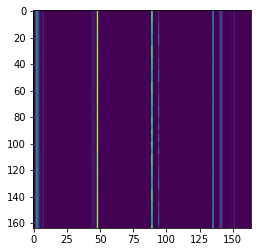

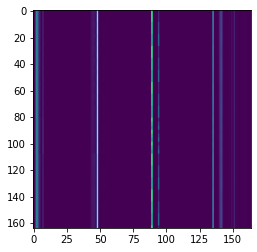

In [17]:
plt.imshow(c620_wt.head(41*4).values)
plt.show()
plt.imshow(c620_wt_gt.head(41*4).values)

In [18]:
predict.model_c620_sf.show_metrics(c620_wt,c620_wt_gt,e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.946632,0.000703532,1.18406
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.892136,0.332225,1.14148
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0,0.179092,1.00075
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.991745,0.00938604,0.810077
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999994,1.78984e-08,0.0282676
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999994,3.29771e-09,0.0282682
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


# check mass blance c620_wt

In [19]:
for i in range(4):
  assert np.allclose(c620_wt.iloc[:,41*i:41*(i+1)].sum(axis=1),100)
print('pass')

pass


In [20]:
input_mfr = predict.c620_mb.iloc[:,0].values.reshape(-1,1)
w1_mfr = predict.c620_mb.iloc[:,1].values.reshape(-1,1)
w2_mfr = predict.c620_mb.iloc[:,2].values.reshape(-1,1)
w3_mfr = predict.c620_mb.iloc[:,3].values.reshape(-1,1)
w4_mfr = predict.c620_mb.iloc[:,4].values.reshape(-1,1)
入料量 = (c620_x.iloc[:,-41:]*input_mfr).sum(axis=1).values
出料_w1 = (c620_wt.iloc[:,0:41]*w1_mfr).sum(axis=1).values
出料_w2 = (c620_wt.iloc[:,41:41*2]*w2_mfr).sum(axis=1).values
出料_w3 = (c620_wt.iloc[:,41*2:41*3]*w3_mfr).sum(axis=1).values
出料_w4 = (c620_wt.iloc[:,41*3:41*4]*w4_mfr).sum(axis=1).values
np.allclose(入料量,出料_w1+出料_w2+出料_w3+出料_w4)

True

#C620 OP

In [21]:
c620_op = predict.c620_op(c620_x)
c620_op.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
001-001,0.862277,0.450823,0.786786,0.881346,0.871862,116.952911,11.859276,13.424045,174.704910,193.072540
001-002,0.862277,0.450823,0.786786,0.881346,0.871862,116.952919,11.859279,13.424048,174.704895,193.072540
001-003,0.862277,0.450823,0.786786,0.881346,0.871862,116.952919,11.859278,13.424048,174.704895,193.072540
001-004,0.862272,0.448892,0.793294,0.881378,0.871861,115.778534,11.899473,13.444139,174.699860,193.098175
001-005,0.862272,0.448892,0.793294,0.881378,0.871861,115.778549,11.899474,13.444139,174.699860,193.098175


In [22]:
c620_op_gt = predict.c620_df.loc[c620_op.index,c620_op.columns]
c620_op_gt.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
001-001,0.862264,0.449632,0.784431,0.881339,0.871859,116.902473,11.831793,13.421467,174.679169,193.078064
001-002,0.862264,0.449633,0.784431,0.881339,0.871859,116.913414,11.832891,13.420790,174.680298,193.079437
001-003,0.862264,0.449633,0.784431,0.881339,0.871859,116.907753,11.832324,13.420931,174.679718,193.078735
001-004,0.862264,0.447516,0.790220,0.881372,0.871859,115.686234,11.881908,13.417187,174.687775,193.097900
001-005,0.862264,0.447516,0.790220,0.881372,0.871859,115.692726,11.882563,13.416693,174.688446,193.098572


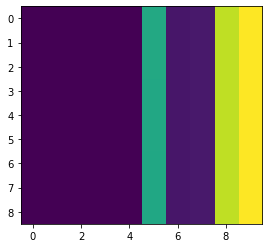

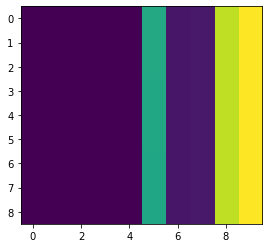

In [23]:
plt.imshow(c620_op.head(9).values)
plt.show()
plt.imshow(c620_op_gt.head(9).values)

In [24]:
predict.model_c620_op.show_metrics(c620_op,c620_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Feed Properties,0.999952,7.12149e-11,0.000690712
Density_Vent Gas Production Rate and Composition,0.47681,7.85505e-06,0.508387
Density_Distillate Production Rate and Composition,0.476983,3.79286e-05,0.639799
Density_Sidedraw Production Rate and Composition,0.999661,3.82308e-10,0.00169779
Density_Bottoms Production Rate and Composition,0.99967,5.4422e-12,0.000208542
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.998676,0.172791,0.257589
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.997913,0.00244379,0.298594
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.998857,0.00186725,0.237681
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.999116,0.00114925,0.0157231
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.998616,0.00107817,0.0129881


#C660 WT

In [25]:
#C660 Input
c660_x = predict.load_c660(c620_wt[predict.c620_col_names['sidedraw_x']])
c660_x.head()

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
001-001,979.958380,10.000000,0.0,0.000176,0.011380,0.021714,0.014906,0.019344,0.029843,66.266615,0.020957,0.034411,0.0,0.014618,27.885553,0.028612,0.024798,0.020281,3.132131,0.632325,1.318010,0.365564,0.044484,1.932615e-08,0.098763,3.366684e-09,0.001142,0.001141,0.002230,0.000570,0.000570,0.007880,3.853450e-09,1.666444e-10,0.001555,0.000415,6.017642e-10,0.0,6.448952e-12,3.082957e-13,2.994304e-16,0.0,0.0
001-002,979.858033,5.000000,0.0,0.000176,0.011380,0.021714,0.014906,0.019344,0.029843,66.266618,0.020957,0.034411,0.0,0.014618,27.885548,0.028612,0.024798,0.020281,3.132132,0.632326,1.318010,0.365564,0.044484,1.932607e-08,0.098764,3.366671e-09,0.001142,0.001141,0.002230,0.000570,0.000570,0.

In [26]:
c660_wt = predict.c660_wt(c660_x)
c660_wt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [27]:
c660_wt_gt = predict.c660_df.loc[c660_wt.index,c660_wt.columns]
c660_wt_gt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

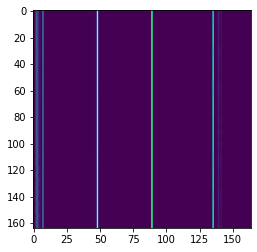

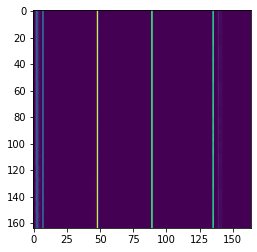

In [28]:
plt.imshow(c660_wt.head(41*4).values)
plt.show()
plt.imshow(c660_wt_gt.head(41*4).values)

In [29]:
predict.model_c660_sf.show_metrics(c660_wt,c660_wt_gt,e=2e-2)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.951068,0.00648945,4.45255
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.991553,0.312575,1.96749
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.952109,0.212424,1.41228
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.990337,0.11942,3.62667
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.99985,2.27121e-27,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999864,2.49638e-33,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


# check mass blance c660_wt

In [30]:
for i in range(4):
  assert np.allclose(c660_wt.iloc[:,41*i:41*(i+1)].sum(axis=1),100)
print('pass')

pass


In [31]:
input_mfr = predict.c660_mb.iloc[:,0].values.reshape(-1,1)
w1_mfr = predict.c660_mb.iloc[:,1].values.reshape(-1,1)
w2_mfr = predict.c660_mb.iloc[:,2].values.reshape(-1,1)
w3_mfr = predict.c660_mb.iloc[:,3].values.reshape(-1,1)
w4_mfr = predict.c660_mb.iloc[:,4].values.reshape(-1,1)
入料量 = (c660_x.iloc[:,-41:]*input_mfr).sum(axis=1).values
出料_w1 = (c660_wt.iloc[:,0:41]*w1_mfr).sum(axis=1).values
出料_w2 = (c660_wt.iloc[:,41:41*2]*w2_mfr).sum(axis=1).values
出料_w3 = (c660_wt.iloc[:,41*2:41*3]*w3_mfr).sum(axis=1).values
出料_w4 = (c660_wt.iloc[:,41*3:41*4]*w4_mfr).sum(axis=1).values
np.allclose(入料量,出料_w1+出料_w2+出料_w3+出料_w4)

True

#C660 OP

In [32]:
c660_op = predict.c660_op(c660_x)
c660_op.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
001-001,0.878638,0.529258,0.870875,0.883698,0.870055,93.565331,9.283819,8.690313,86.378822,88.632668
001-002,0.878649,0.532477,0.869943,0.883699,0.870049,98.443878,9.721480,9.128470,86.405823,88.686104
001-003,0.878654,0.535342,0.869111,0.883699,0.870039,105.030212,10.326077,9.739618,86.444267,88.782364
001-004,0.878600,0.529358,0.870968,0.883704,0.870058,92.096458,9.140115,8.576165,86.371925,88.623573
001-005,0.878614,0.532588,0.870110,0.883704,0.870063,97.037552,9.580200,9.010795,86.397903,88.672783


In [33]:
c660_op_gt = predict.c660_df.loc[c660_op.index,c660_op.columns]
c660_op_gt.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
001-001,0.878584,0.527970,0.871164,0.883697,0.870042,92.053581,9.170740,8.579609,86.367523,88.610596
001-002,0.878584,0.532121,0.869987,0.883697,0.870040,97.747383,9.671293,9.089737,86.398682,88.668610
001-003,0.878584,0.535616,0.868997,0.883697,0.870039,104.241364,10.260563,9.686745,86.436920,88.776123
001-004,0.878581,0.526486,0.871840,0.883705,0.870041,91.088814,9.095900,8.514075,86.364777,88.596405
001-005,0.878581,0.530887,0.870613,0.883705,0.870039,96.766853,9.590916,9.018928,86.395142,88.651093


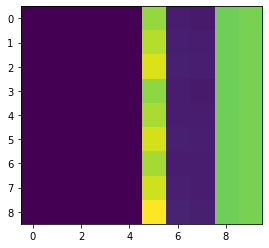

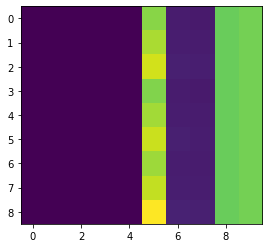

In [34]:
plt.imshow(c660_op.head(9).values)
plt.show()
plt.imshow(c660_op_gt.head(9).values)

In [35]:
predict.model_c660_op.show_metrics(c660_op,c660_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Feed Properties,0.99818,1.36821e-09,0.00326402
Density_Vent Gas Production Rate and Composition,0.994154,1.81893e-06,0.193579
Density_Distillate (Benzene Drag) Production Rate and Composition,0.993803,4.74345e-07,0.0570471
Density_Sidedraw (Benzene )Production Rate and Composition,0.986449,1.28727e-12,0.00010008
Density_Bottoms Production Rate and Composition,0.998718,9.84645e-11,0.000856713
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.997938,1.72075,0.764863
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.997627,0.0152843,0.751999
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.997371,0.0182172,0.809783
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.997611,0.000104341,0.0090871
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.996999,0.00239696,0.0411572


# C670 WT

In [36]:
#C670 Input
c620_w4,c660_w4 = c620_wt[predict.c620_col_names['bottoms_x']],c660_wt[predict.c660_col_names['bottoms_x']]
c670_x = predict.load_c670(c620_w4,c660_w4)
c670_x.head()

,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Hydrogen_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Propane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Butane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Pentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Hexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Benzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Heptane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Water_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Toluene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Octane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_p-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_m-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_o-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Nonane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Indane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2-Diethylbenzene_wt%",Tol

In [37]:
c670_wt = predict.c670_wt(c670_x)
c670_wt = c670_wt.dropna(axis=0)
c670_wt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [38]:
c670_wt_gt = predict.c670_df.loc[c670_wt.index,c670_wt.columns]
c670_wt_gt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

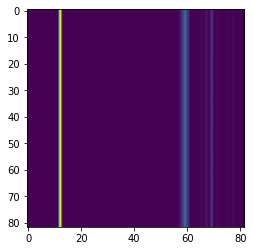

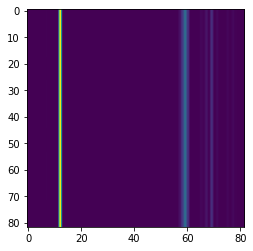

In [39]:
plt.imshow(c670_wt.head(41*2).values)
plt.show()
plt.imshow(c670_wt_gt.head(41*2).values)

In [40]:
predict.model_c670_sf.show_metrics(c670_wt,c670_wt_gt,e=2e-2)

,R2,MSE,MAPE
Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,0,3.82619e-11,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,0,2.27113e-08,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,0,1.83282e-08,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,0,6.18126e-47,NaN
...,...,...,...
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1,5.92881e-09,0.00708037
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1,1.09986e-09,0.0070619
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


# check massblance c670_wt

In [41]:
for i in range(2):
  assert np.allclose(c670_wt.iloc[:,41*i:41*(i+1)].sum(axis=1),100)
print('pass')

pass


In [42]:
input_mfr = predict.c670_mb.iloc[:,[0,1]].sum(axis=1).values.reshape(-1,1)
w1_mfr = predict.c670_mb.iloc[:,2].values.reshape(-1,1)
w2_mfr = predict.c670_mb.iloc[:,3].values.reshape(-1,1)
入料量 = (c670_x.iloc[:,:41]*input_mfr).sum(axis=1).values
出料_w1 = (c670_wt.iloc[:,0:41]*w1_mfr).sum(axis=1).values
出料_w2 = (c670_wt.iloc[:,41:41*2]*w2_mfr).sum(axis=1).values
np.allclose(入料量,出料_w1+出料_w2)

True

#C670 OP

In [43]:
c670_op = predict.c670_op(c670_x)
c670_op.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
001-001,0.870896,0.872376,235.262207,25.047569,25.641676,181.763214,224.673859
001-002,0.870896,0.872379,235.041458,25.020903,25.614504,181.762878,224.667587
001-003,0.870896,0.872382,234.853119,24.999035,25.591864,181.762802,224.662979
001-004,0.870896,0.872375,235.112900,25.032314,25.623947,181.763947,224.670761
001-005,0.870896,0.872378,234.887924,25.006104,25.597223,181.763474,224.664673


In [44]:
c670_op_gt = predict.c670_df.loc[c670_op.index,c670_op.columns]
c670_op_gt.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
001-001,0.870898,0.872382,237.497345,25.174679,25.868053,181.798798,224.620972
001-002,0.870897,0.872382,237.501434,25.175015,25.867839,181.798828,224.621002
001-003,0.870897,0.872382,237.496521,25.174639,25.868182,181.798706,224.620972
001-004,0.870898,0.872382,237.723160,25.192291,25.860675,181.803101,224.622864
001-005,0.870897,0.872382,237.728455,25.192725,25.860317,181.803192,224.622925


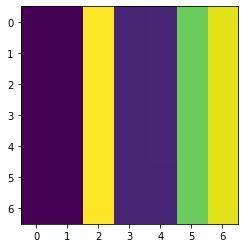

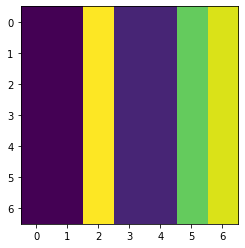

In [45]:
plt.imshow(c670_op.head(7).values)
plt.show()
plt.imshow(c670_op_gt.head(7).values)

In [46]:
predict.model_c670_op.show_metrics(c670_op,c670_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0.996548,2.8377e-12,0.000139678
Density_Bottoms Production Rate and Composition,0.998571,2.55669e-10,0.00141631
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.986609,8.52936,0.865115
Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.988405,0.102067,0.796613
Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.987282,0.107586,0.816822
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0.98866,0.0006824,0.0111023
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.995629,0.0114674,0.0323118
AVG,0.991672,1.25017,0.360503
